In [2]:
import os
import sys
os.environ["UW_ENABLE_TIMING"] = "1"
import underworld as uw
from underworld import function as fn
from underworld.scaling import units as u
from underworld.scaling import dimensionalise as dm, non_dimensionalise as nd
import glucifer
import numpy as np

In [3]:
#
# Scaling and Units
#
# Dimentional Parameters
airHeight=50.*u.kilometer
modelHeight = 2891 * u.kilometer
earthRadius = 6371 * u.kilometer
modelCartAspect=2
ThetaRAD=np.rad2deg((modelHeight*modelCartAspect)/earthRadius)

# plateHeight = 120. * u.kilometer
refDensity = 3200.0 * u.kilogram / u.meter ** 3
deltaRhoMax = 80.0 * u.kilogram / u.meter ** 3
gravity = 9.8 * u.metre / u.second ** 2
# 1.57e20 * u.pascal * u.second 5.e20 * u.pascal * u.second
refViscosity = 5.0e20 * u.pascal * u.second
bodyForce = deltaRhoMax * gravity

# scaling coefficients
K_eta = refViscosity
KL = modelHeight
K_tau = bodyForce * modelHeight
K_v = K_tau * modelHeight / K_eta
# Kt = KL/K_v
Kt = K_eta / K_tau
KM = K_tau * modelHeight * Kt ** 2

scaling_coefficients = uw.scaling.get_coefficients()

scaling_coefficients["[length]"] = KL.to_base_units()
# scaling_coefficients["[temperature]"] = KT.to_base_units()
scaling_coefficients["[time]"] = Kt.to_base_units()
scaling_coefficients["[mass]"] = KM.to_base_units()

In [4]:
step=0
time=0.
maxSteps=1
outputDir='AnnSubBenchmark'

In [19]:
mesh = uw.mesh.FeMesh_Annulus(
        elementRes = (128,128),
        radialLengths = (nd(earthRadius-modelHeight+airHeight),nd(earthRadius)),
        angularExtent=((180-ThetaRAD.magnitude)/2,90+ThetaRAD.magnitude/2)
)
        


velocityField       = mesh.add_variable( nodeDofCount=2 )
pressureField       = mesh.subMesh.add_variable( nodeDofCount=1 )
lower = mesh.specialSets["MinI_VertexSet"]
upper = mesh.specialSets["MaxI_VertexSet"]
swarm = uw.swarm.Swarm(mesh, particleEscape=True)
materialVariable=swarm.add_variable(count=1,dataType="int")
layout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm, particlesPerCell=10)
swarm.populate_using_layout(layout)
advector = uw.systems.SwarmAdvector(velocityField=velocityField, swarm=swarm)


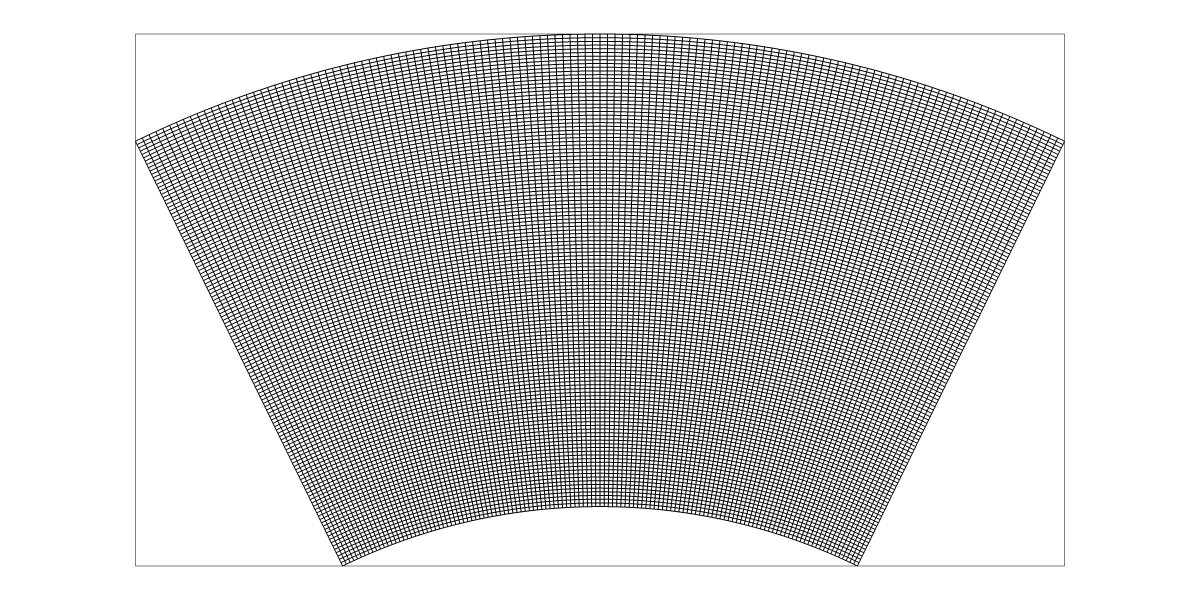

In [20]:
store=None
fig = glucifer.Figure(store=store,figsize=(1200,600))
# fig.append( glucifer.objects.Mesh( mesh ,nodeNumbers=True))
fig.append( glucifer.objects.Mesh( mesh ))
# fig.append( glucifer.objects.Points( swarm,pointsize=4))
fig.show()

In [21]:
radialFn = fn.math.sqrt(fn.math.dot(fn.coord(), fn.coord()))
thetaFn = fn.math.atan2(fn.coord()[1], fn.coord()[0])


In [22]:
# thetaFn.evaluate()


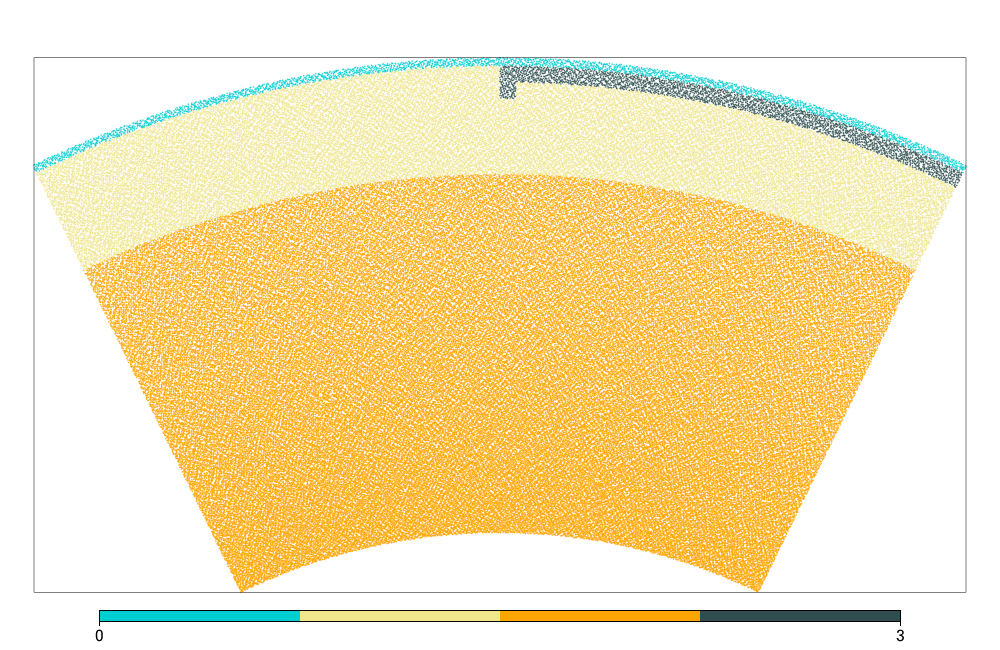

In [23]:
air=mesh.unit_heightFn.evaluate(swarm.data)>nd(modelHeight-airHeight)
lowermantle=mesh.unit_heightFn.evaluate(swarm.data)<nd(modelHeight-airHeight-660.*u.kilometer)
slab=(mesh.unit_heightFn.evaluate(swarm.data)<nd(modelHeight-airHeight)) & \
     (mesh.unit_heightFn.evaluate(swarm.data)>nd(modelHeight-airHeight-100.*u.kilometer)) & \
     (mesh.thetaFn.evaluate(swarm.data)<=np.pi/2)
perturb=(mesh.unit_heightFn.evaluate(swarm.data)<nd(modelHeight-airHeight)) & \
        (mesh.unit_heightFn.evaluate(swarm.data)>nd(modelHeight-airHeight-200.*u.kilometer)) & \
        (mesh.thetaFn.evaluate(swarm.data)<=np.pi/2) & \
        (mesh.thetaFn.evaluate(swarm.data)>=np.pi/2-(100.*u.kilometer/earthRadius).magnitude)
materialVariable.data[:]=1
materialVariable.data[air]=0
materialVariable.data[lowermantle]=2
materialVariable.data[slab|perturb]=3
store=None
figP = glucifer.Figure(store=store,figsize=(1000,650))
# fig.append( glucifer.objects.Mesh( mesh))
figP.append( glucifer.objects.Points( swarm,materialVariable,colours='#00CED1 #F0E68C #FFA500 #2F4F4F',pointsize=2,discrete=True))
figP.show()

In [24]:
def checkpoint(mesh,fieldDict,swarm,swarmDict,index,modeltime=None,meshName="mesh",swarmName="swarm",prefix="./",enable_xdmf=True,):
    # Check the prefix is valid
    if prefix is not None:
        if not prefix.endswith("/"):
            prefix += "/"  # add a backslash
        if not os.path.exists(prefix) and uw.mpi.rank == 0:
            print("Creating directory: ", prefix)
            os.makedirs(prefix)

    uw.mpi.barrier()

    if not isinstance(index, int):
        raise TypeError("'index' is not of type int")
    if modeltime is not None:
        time = modeltime
    else:
        time = index

    ii = str(index).zfill(5)

    if mesh is not None:

        # Error check the mesh and fields
        if not isinstance(mesh, uw.mesh.FeMesh):
            raise TypeError("'mesh' is not of type uw.mesh.FeMesh")
        if not isinstance(fieldDict, dict):
            raise TypeError("'fieldDict' is not of type dict")
        for key, value in fieldDict.items():
            if not isinstance(value, uw.mesh.MeshVariable):
                raise TypeError(
                    "'fieldDict' must contain uw.mesh.MeshVariable elements"
                )

        # see if we have already saved the mesh. It only needs to be saved once
        if not hasattr(checkpoint, "mH"):
            checkpoint.mH = mesh.save(prefix + meshName + ".h5")
        mh = checkpoint.mH

        for key, value in fieldDict.items():
            filename = prefix + key + "-" + ii
            handle = value.save(filename + ".h5")
            if enable_xdmf:
                value.xdmf(filename, handle, key, mh, meshName, modeltime=time)

    # is there a swarm
    if swarm is not None:

        # Error check the swarms
        if not isinstance(swarm, uw.swarm.Swarm):
            raise TypeError("'swarm' is not of type uw.swarm.Swarm")
        if not isinstance(swarmDict, dict):
            raise TypeError("'swarmDict' is not of type dict")
        for key, value in swarmDict.items():
            if not isinstance(value, uw.swarm.SwarmVariable):
                raise TypeError(
                    "'fieldDict' must contain uw.swarm.SwarmVariable elements"
                )

        sH = swarm.save(prefix + swarmName + "-" + ii + ".h5")
        for key, value in swarmDict.items():
            filename = prefix + key + "-" + ii
            handle = value.save(filename + ".h5")
            if enable_xdmf:
                value.xdmf(filename, handle, key, sH, swarmName, modeltime=time)

In [25]:
# iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
# jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
# tWalls = mesh.specialSets["MaxJ_VertexSet"]
upperSurf = mesh.specialSets["upper_surface_VertexSet"]
lowerSurf = mesh.specialSets["lower_surface_VertexSet"]
rightWall = mesh.specialSets["Right_VertexSet"]
leftWall  = mesh.specialSets["Left_VertexSet"]
# freeslipBC = uw.conditions.DirichletCondition(
#     variable=velocityField, indexSetsPerDof=(iWalls, jWalls)
# )
def setVbc():
    velocityField.data[...] = 0.
    velocityField.data[upperSurf.data,:] = (0.0,0.0)
    velocityField.data[lowerSurf.data,:] = (0.0,0.0)
    velocityField.data[leftWall.data,:] = (0.0,0.0)
    velocityField.data[leftWall.data,:] = (0.0,0.0)
    
setVbc()

    
freeSlipAn = uw.conditions.RotatedDirichletCondition( variable=velocityField,
                                                 indexSetsPerDof=(upperSurf+lowerSurf,rightWall+leftWall),
                                                 basis_vectors = (mesh.bnd_vec_normal, mesh.bnd_vec_tangent)) 

In [26]:
airDensity=-1.
mantleDensity=0.
slabDensity=1.
densityMap = { 0 : airDensity,
               1 : mantleDensity, 
               2 : mantleDensity, 
               3 : slabDensity}
densityFn = fn.branching.map( fn_key = materialVariable, mapping = densityMap )
buoyancyFn = -1.0 * densityFn * mesh.unitvec_r_Fn


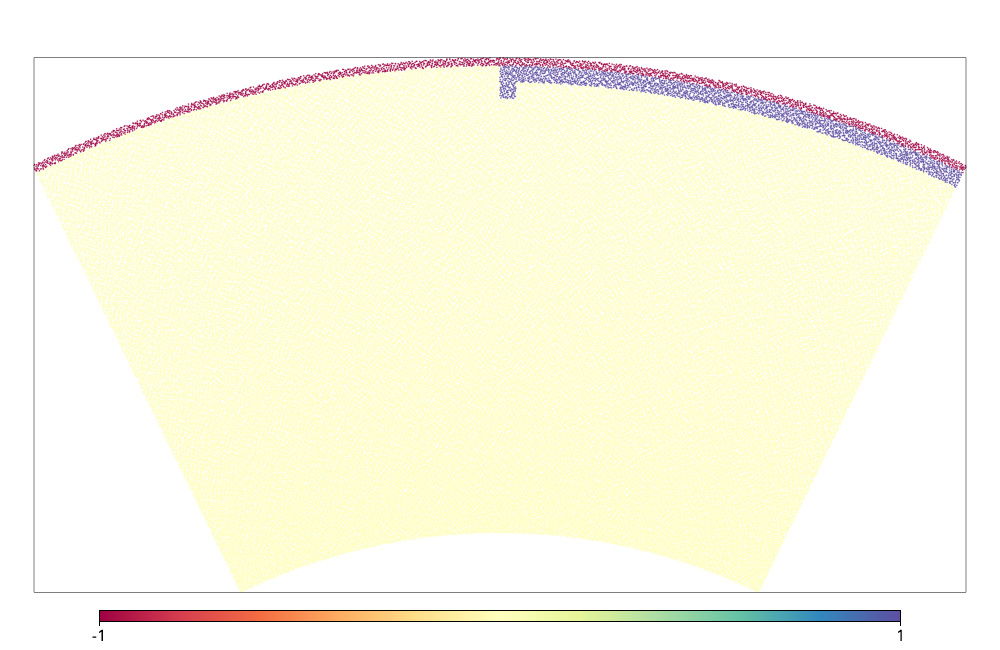

In [27]:
figD = glucifer.Figure(store=store,figsize=(1000,650))
# fig.append( glucifer.objects.Mesh( mesh))
figD.append( glucifer.objects.Points( swarm,densityFn,colours='spectral',pointsize=2))
figD.show()

In [28]:
airViscosity=1e-2
mantleViscosity=1.
lowermantleViscosity=1e2
slabViscosity=1e2
viscosityMap = {0 : airViscosity,
                1 : mantleViscosity, 
                2 : lowermantleViscosity, 
                3 : slabViscosity}
viscosityFn = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap )


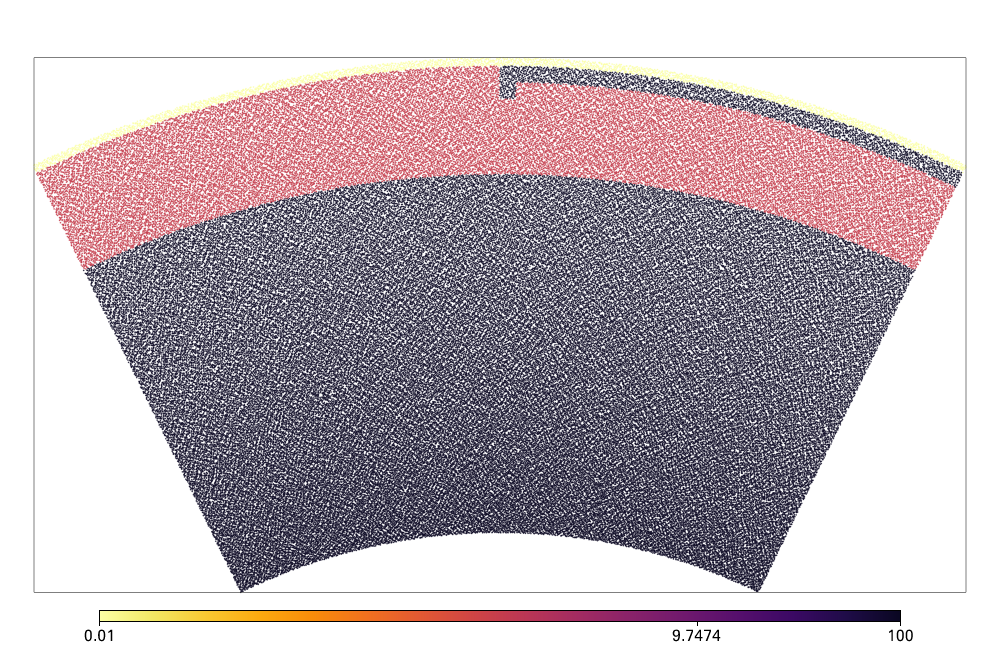

In [29]:
figV = glucifer.Figure(store=store,figsize=(1000,650))
# fig.append( glucifer.objects.Mesh( mesh))
figV.append( glucifer.objects.Points( swarm,viscosityFn,pointsize=2,logScale=True,colours=glucifer.lavavu.matplotlib_colourmap('inferno_r')))
figV.show()

In [49]:
fieldDict = {
    "velocity": velocityField,
    "pressure": pressureField,
#     "meshViscosity": projVisc,
}

swarmDict = {"materials": materialVariable}
# traceDict = {"tcoords": tincord, "tvel": tracerVelocity}

In [50]:
checkpoint(
        mesh,
        fieldDict,
        swarm,
        swarmDict,
        index=step,
        modeltime=dm(time, 1.0 * u.megayear).magnitude,
        prefix=outputDir,
    )

In [51]:
stokesSLE_AN = uw.systems.Curvilinear_Stokes( velocityField, pressureField, 
                                               fn_viscosity=viscosityFn, 
                                               fn_bodyforce=buoyancyFn,
                                               conditions=freeSlipAn,
                                              _removeBCs=False)

In [52]:
stokesSolverAN = uw.systems.Solver(stokesSLE_AN)

stokesSolverAN.options.A11.ksp_type="fgmres"
stokesSolverAN.options.scr.ksp_rtol=1.0e-4
stokesSolverAN.options.scr.ksp_max_it=100
stokesSolverAN.options.scr.ksp_monitor="ascii"
stokesSolverAN.options.scr.ksp_type="fgmres"
stokesSolverAN.options.A11.ksp_rtol=1.0e-5
stokesSolverAN.options.A11.ksp_monitor="ascii"

stokesSolverAN.set_penalty(10.0)
stokesSolverAN.options.main.restore_K=True
stokesSolverAN.options.main.force_correction=True
stokesSolverAN.options.main.Q22_pc_type="gkgdiag"

stokesSolverAN.options.mg_accel.mg_accelerating_smoothing=True
stokesSolverAN.options.mg_accel.mg_smooths_to_start=3
stokesSolverAN.options.mg_accel.mg_smooths_max=10
stokesSolverAN.options.mg.mg_levels_ksp_convergence_test='skip'
stokesSolverAN.options.mg.mg_levels_ksp_norm_type='none'
stokesSolverAN.options.mg.mg_levels_ksp_max_it=5
stokesSolverAN.options.mg.mg_levels_ksp_type="chebyshev"
stokesSolverAN.options.mg.mg_coarse_pc_type="lu"
stokesSolverAN.options.mg.mg_coarse_pc_factor_mat_solver_package="mumps"

In [57]:
# stokesSolverAN.solve(print_stats=True, reinitialise=True)

In [59]:
# uw.libUnderworld.Underworld.AXequalsX( stokesSLE_AN._rot._cself, stokesSLE_AN._velocitySol._cself, False)

In [67]:
vc = uw.mesh.MeshVariable(mesh = mesh, nodeDofCount = 2)
vc_eqNum = uw.systems.sle.EqNumber(vc, False )
vcVec = uw.systems.sle.SolutionVector(vc, vc_eqNum)

def postSolve():
    uw.libUnderworld.Underworld.AXequalsY(
        stokesSLE_AN ._rot._cself,
        stokesSLE_AN ._velocitySol._cself,
        vcVec._cself,
        False
        )
    uw.libUnderworld.StgFEM.SolutionVector_RemoveVectorSpace(
        stokes._velocitySol._cself, 
        stokes._vnsVec._cself
        )

In [72]:
while step<maxSteps:
    velocityField.data[:] = 0.
    stokesSolverAN.solve(callback_post_solve = postSolve)

    uw.libUnderworld.Underworld.AXequalsX(
        stokes._rot._cself,
        stokes._velocitySol._cself,
        False
    )
    step+=1

RuntimeError: Error encountered. Full restart recommended as exception safety not guaranteed. Error message:
Failed to execute the callback function, please check if it's valid


In [73]:
checkpoint(
        mesh,
        fieldDict,
        swarm,
        swarmDict,
        index=step,
        modeltime=dm(time, 1.0 * u.megayear).magnitude,
        prefix=outputDir,
    )

In [65]:
uw.systems.sle.SolutionVector??